#Task b)  

In [23]:
import pandas as pd
from google.colab import drive
import pandas as pd
import sklearn.linear_model as lm
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
import sys
import time


np.random.seed(0) # For reproducibility
FIGSIZE = (8,5)
splits = 10 # Number of splits for cross-validation


# These parameters affect execution time 
t_test = 1e-3 #Tolerance stopping criteria when performing the regression to test predictions 
t_cross = 6e-3 #Tolerance stopping criteria when performing the regression for cross-validation

nmax_test = 1000 #Maximum number of iterations when performing the regression to test predictions
nmax_cross = 500 #Maximum number of iterations when performing the regression for cross-validation


# Loading the training and testing data 
drive.mount('/content/gdrive')

trainingData=pd.read_csv('gdrive/My Drive/bmdslab/final project/glm.training.data.csv', index_col = 0) # Index_col = 0 to use the first column as indices
testData=pd.read_csv('gdrive/My Drive/bmdslab/final project/glm.test.data.csv', index_col = 0)
timestamps=pd.read_csv('gdrive/My Drive/bmdslab/final project/timestamps.test.csv', index_col = 0) 
onsets=pd.read_csv('gdrive/My Drive/bmdslab/final project/test.onsets.csv', index_col = 0)

format = "%Y-%m-%d %H:%M:%S" #This time format will be necessary to process warning time 

f = 1/8 # The fraction of the total training set used (to lower execution time)
# Use f = 1 to use the entire dataset
# Note that time remaining is estimated for cross-validation (the longest task)
n_points = int(f*len(trainingData))
trainingData = shuffle(trainingData)
trainingData = trainingData.iloc[:n_points,:]




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
# Separating predictor variables from labels 
xTrain = trainingData.drop(columns = ['y'])
yTrain = trainingData['y']



# Normalizing each column of xTrain
scaler = preprocessing.StandardScaler()
scaled_xTrain = scaler.fit_transform(xTrain)
xTrain = pd.DataFrame(scaled_xTrain, columns=xTrain.columns)

Area under the curve: 0.9334


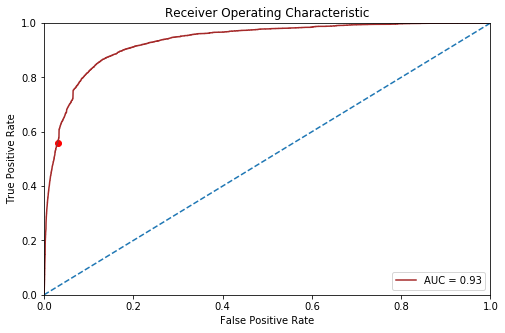

In [25]:
 # Training a logistic regression with the saga solver and lasso penalty
lr = lm.LogisticRegression(fit_intercept=True, solver = 'saga', penalty = 'l1', C = 1, tol = t_test, max_iter = nmax_test)
fit = lr.fit(xTrain, yTrain)

# Predicting probabilities from training sample and plotting roc_curve
phat = fit.predict_proba(xTrain)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(yTrain, phat)
roc_auc_before = metrics.auc(fpr, tpr)
dst = [abs(0.5 - el) for el in thresholds]
closest_ = np.argmin(dst)

plt.figure(figsize=FIGSIZE)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'brown', label = 'AUC = %0.2f' % roc_auc_before)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(fpr[closest_], tpr[closest_], c = 'r')

print("Area under the curve: " + str(np.round(roc_auc_before, 5)))

In [26]:
# Evaluating performance on the test set using a risk score of 0.5 as threshold
xTest = testData.drop(columns = ['y', 'patient'])
yTest = testData['y']
scaled_xTest = scaler.fit_transform(xTest)
xTest = pd.DataFrame(scaled_xTest, columns=xTest.columns)

yhat = (fit.predict_proba(xTest)[:,1] >= 0.5)
accuracy = np.round(np.mean(yhat == yTest), 3)
sensitivity = np.round(np.mean(yhat[yTest == 1] == yTest[yTest == 1]), 3)
specificity = np.round(np.mean(yhat[yTest == 0] == yTest[yTest == 0]), 3)


PPV = tpr[closest_]/(tpr[closest_] + fpr[closest_])
d = {'Accuracy': [accuracy], 'Sensitivity': [sensitivity], 'Specificity': [specificity], 'PPV': [PPV]}
df = pd.DataFrame(data=d)
df = df.style.hide_index()
print("Evaluation of the predictions on the testing set with 0.5 as classification threshold and 1 as regularization strength: \n")
df

Evaluation of the predictions on the testing set with 0.5 as classification threshold and 1 as regularization strength: 



Accuracy,Sensitivity,Specificity,PPV
0.865,0.261,0.924,0.948871


#Task c)
**Cross-validation**

In [27]:
n = np.linspace(-4,1,7)
lambdas = [2**el for el in n]

auc = np.zeros((10, len(lambdas)))

yy =  trainingData['y']
xx = trainingData.drop(columns = ['y'])

kf = KFold(n_splits=splits)

j = 0
k = 0
start = time.time()
for train_index, test_index in kf.split(xx):  
  X, XTEST = xx.iloc[train_index], xx.iloc[test_index]
  Y, YTEST = yy.iloc[train_index], yy.iloc[test_index]
  scaled_X = scaler.fit_transform(X)
  X = pd.DataFrame(scaled_X, columns=X.columns)
  scaled_XTEST = scaler.fit_transform(XTEST)
  XTEST = pd.DataFrame(scaled_XTEST, columns=XTEST.columns)
  
  for l in range(len(lambdas)):
    if (j > 0):
      fraction_done = j/(splits*len(lambdas))
      elapsed = (time.time()-start)
      remaining = (1-fraction_done)/fraction_done*elapsed
      hours, rem = divmod(remaining, 3600)
      minutes, seconds = divmod(rem, 60)
      message = '\r'+ str(np.round(100*fraction_done,2))
      message += "% done, estimated time remaining: " 
      message += "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)    
      sys.stdout.write(message)
    
    
    # Training a logistic regression with the saga solver and lasso penalty
    lr = lm.LogisticRegression(fit_intercept=True, solver = 'saga', penalty = 'l1', C = 1/lambdas[l], tol = t_cross, max_iter = nmax_cross)
    fit = lr.fit(X, Y)

    # Predicting probabilities from training sample and plotting roc_curve
    phat = fit.predict_proba(XTEST)[:,1]

    fpr, tpr, thresholds = metrics.roc_curve(YTEST, phat);
    auc[k,l] = metrics.auc(fpr, tpr)
    j += 1
  k += 1
sys.stdout.write('\r')
  
auc_avg = []
for m in range(len(lambdas)): 
  auc_avg.append(np.mean(auc[:,m]))

i = np.argmax(auc_avg)
optimal_lambda = lambdas[i]
print(" The optimal regularization strength is: " + str(optimal_lambda))

 The optimal regularization strength is: 0.6299605249474366


Text(0.5, 0, 'Regularization strength')

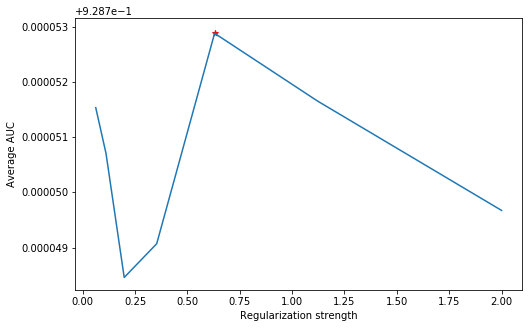

In [28]:
plt.figure(figsize=FIGSIZE)
plt.plot(lambdas, auc_avg)
plt.scatter(optimal_lambda, auc_avg[i], color='r', marker = "*")
plt.ylabel('Average AUC')
plt.xlabel('Regularization strength')

#Part d)

**Finding the optimal threshold**

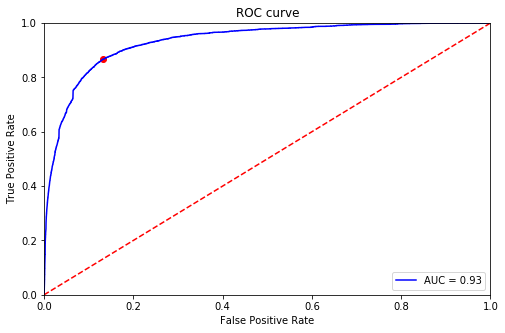

In [29]:
# Now use the optimal regularization parameter 

lr = lm.LogisticRegression(fit_intercept=True, solver = 'saga', penalty = 'l1', C = 1/optimal_lambda, tol = t_test, max_iter = nmax_test)
fit = lr.fit(xTrain,yTrain)

# Predicting probabilities from training sample and plotting roc_curve
phat = fit.predict_proba(xTrain)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(yTrain, phat)
roc_auc = metrics.auc(fpr, tpr)
distances_sq = []
for i in range(len(thresholds)): 
  distances_sq.append((tpr[i]-1)**2 + (fpr[i])**2 )
best_index = np.argmin(distances_sq)
best_threshold = thresholds[best_index]

plt.figure(figsize=FIGSIZE)
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(fpr[best_index], tpr[best_index], c = 'r')
plt.show()



In [30]:
# Evaluating performance on test set using the optimal regularization strength and classification threshold
yhat = (fit.predict_proba(xTest)[:,1] >= best_threshold)
accuracy = np.round(np.mean(yhat == yTest), 3)
sensitivity = np.round(np.mean(yhat[yTest == 1] == yTest[yTest == 1]), 3)
specificity = np.round(np.mean(yhat[yTest == 0] == yTest[yTest == 0]), 3)
PPV = tpr[best_index]/(tpr[best_index] + fpr[best_index])
d = {'Accuracy': [accuracy], 'Sensitivity': [sensitivity], 'Specificity': [specificity], 'PPV' : [PPV ] }
df = pd.DataFrame(data=d)
frame = df.style.hide_index()
print("Evaluation of the predictions on the testing set with " + str(np.round(best_threshold,5)) +" as classification threshold and " + str(optimal_lambda) + " as regularization strength: \n")
frame

Evaluation of the predictions on the testing set with 0.18595 as classification threshold and 0.6299605249474366 as regularization strength: 



Accuracy,Sensitivity,Specificity,PPV
0.794,0.446,0.828,0.868521


#Part e)
**Generating a histogram of EWT**

In [0]:
# STEP 1: extract only those that eventually go in septic shock
shook = testData[testData.y == 1]

In [0]:
# STEP 2: add their ids
ids = []
for index, row in shook.iterrows(): 
  if row['patient'] not in ids: 
    ids.append(int(row['patient']))


In [0]:
#STEP 3: for each ID, take their first measurement where they were predicted as in pre-septic shock
# We need to make predictions on testing set this time 


times = []
for id in ids: 
  patient_msrmts = testData.loc[testData.patient == id]
  found = False
  for index, row in patient_msrmts.iterrows(): 
    if (not found): 
      if (yhat[index] == 1): 
        times.append(timestamps.iloc[index]['x'])
        found = True
  if (not found):
    times.append(None)
        
df = pd.DataFrame({'Patient':ids,'Detection':times})

Median Early Warning Time: 3.5416666666666665 hours


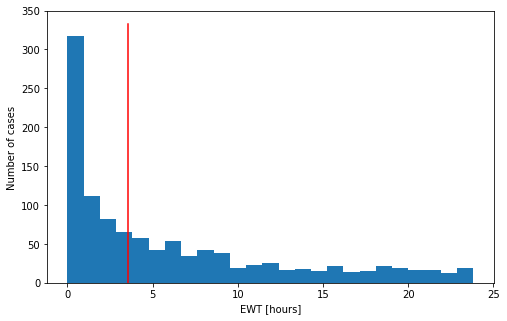

In [34]:
EWT = []
for i in range(len(onsets)):
  if (df.iloc[i,1] is not None):
    t1 = datetime.strptime(str(df.iloc[i,1]), format)
    t2 = datetime.strptime(onsets.iloc[i,0], format)
    d = t2-t1 
    EWT.append(d.seconds/3600)
  else:
    EWT.append(0)
  
median_EWT = np.median(EWT)
plt.figure(figsize=FIGSIZE)
plt.hist(EWT, 25)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot([median_EWT,median_EWT],[ymin,ymax], '-r');
plt.ylabel('Number of cases')
plt.xlabel('EWT [hours]')
print("Median Early Warning Time: " + str(median_EWT) +  " hours")




#Part f)
Repeating the process with balanced data

Text(0.5, 0, 'Regularization strength')

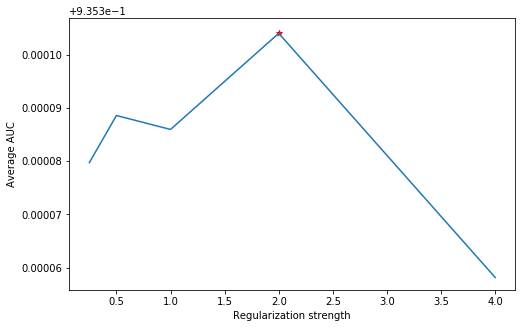

In [35]:
# Balancing the data 
N_shook = len(trainingData[trainingData.y == 1])

ind = trainingData.index.values
np.random.shuffle(ind)
selected_ind = list(ind[:N_shook])
balancedData = trainingData.loc[selected_ind]


n = np.linspace(-2,2,5)
lambdas = [2**el for el in n]

auc = np.zeros((10, len(lambdas)))
j = 0


yy_b =  balancedData['y']
xx_b = balancedData.drop(columns = ['y'])


kf = KFold(n_splits=10)
start = time.time()

k = 0
for train_index, test_index in kf.split(xx_b):
  X, XTEST = xx_b.iloc[train_index], xx_b.iloc[test_index]
  Y, YTEST = yy_b.iloc[train_index], yy_b.iloc[test_index]
  scaled_X = scaler.fit_transform(X)
  X = pd.DataFrame(scaled_X, columns=X.columns)
  scaled_XTEST = scaler.fit_transform(XTEST)
  XTEST = pd.DataFrame(scaled_XTEST, columns=XTEST.columns)
  
  for l in range(len(lambdas)):
    if (j > 0):
      fraction_done = j/(splits*len(lambdas))
      elapsed = (time.time()-start)
      remaining = (1-fraction_done)/fraction_done*elapsed
      hours, rem = divmod(remaining, 3600)
      minutes, seconds = divmod(rem, 60)
      message = '\r'+ str(np.round(100*fraction_done,2))
      message += "% done, estimated time remaining: " 
      message += "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)    
      sys.stdout.write(message)
    
    # Training a logistic regression with the saga solver and lasso penalty
    lr = lm.LogisticRegression(fit_intercept=True, solver = 'saga', penalty = 'l1', C = 1/lambdas[l], tol = t_cross, max_iter = nmax_cross)
    fit = lr.fit(X, Y)

    # Predicting probabilities from training sample and plotting roc_curve
    phat = fit.predict_proba(XTEST)[:,1]

    fpr, tpr, thresholds = metrics.roc_curve(YTEST, phat)
    auc[k,l] = metrics.auc(fpr, tpr)
    j += 1
  k += 1
sys.stdout.write('\r')
  
auc_avg = []
for m in range(len(lambdas)): 
  auc_avg.append(np.mean(auc[:,m]))
best_index = np.argmax(auc_avg)
optimal_lambda = lambdas[best_index]

plt.figure(figsize=FIGSIZE)
plt.plot(lambdas, auc_avg)
plt.scatter(optimal_lambda, auc_avg[best_index], color='r', marker = "*")
plt.ylabel('Average AUC')
plt.xlabel('Regularization strength')

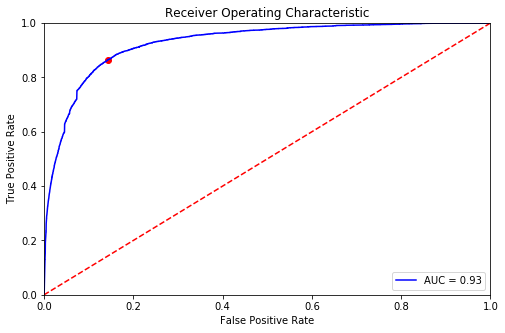

In [36]:

# Now using the optimal regularization parameter 
Y_b = balancedData['y']
X_b = balancedData.drop(columns = ['y'])
scaled_X_b = scaler.fit_transform(X_b)
X_b = pd.DataFrame(scaled_X_b, columns=X_b.columns)


lr = lm.LogisticRegression(fit_intercept=True, solver = 'saga', penalty = 'l1', C = 1/optimal_lambda, tol = t_test, max_iter = nmax_test)
fit = lr.fit(X_b,Y_b)

# Predicting probabilities from training sample and plotting roc_curve
phat = fit.predict_proba(xTrain)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(yTrain, phat)
roc_auc = metrics.auc(fpr, tpr)
distances_sq = []
for i in range(len(thresholds)): 
  distances_sq.append((tpr[i]-1)**2 + (fpr[i])**2 )
k = np.argmin(distances_sq)
best_threshold = thresholds[k]


plt.figure(figsize=FIGSIZE)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.scatter(fpr[k], tpr[k], c = 'r')
plt.show()



# STEP 1: extract only those that eventually go in septic shock
shook = testData[testData.y == 1]

# STEP 2: add their ids
ids = []
for index, row in shook.iterrows(): 
  if row['patient'] not in ids: 
    ids.append(int(row['patient']))
    
#STEP 3: for each ID, take their first measurement where they were predicted as in pre-septic shock
yhat = (fit.predict_proba(xTest)[:,1] >= best_threshold)



times = []
for id in ids: 
  patient_msrmts = testData.loc[testData.patient == id]
  found = False
  for index, row in patient_msrmts.iterrows(): 
    if (not found): 
      if (yhat[index] == 1): 
        times.append(timestamps.iloc[index]['x'])
        found = True
  if (not found):
    times.append(None)
        
df = pd.DataFrame({'Patient':ids,'Detection':times})



EWT = []
for i in range(len(onsets)):
  if (df.iloc[i,1] is not None):
    t1 = datetime.strptime(str(df.iloc[i,1]), format)
    t2 = datetime.strptime(onsets.iloc[i,0], format)
    d = t2-t1 
    EWT.append(d.seconds/3600)
  else: 
    EWT.append(0)
  
median_EWT = np.median(EWT)


In [37]:
# Evaluating performance using the optimal regularization strength and classification threshold
accuracy = np.round(np.mean(yhat == yTest), 3)
sensitivity = np.round(np.mean(yhat[yTest == 1] == yTest[yTest == 1]), 3)
specificity = np.round(np.mean(yhat[yTest == 0] == yTest[yTest == 0]), 3)
PPV = tpr[k]/(tpr[k] + fpr[k])
d = {'Accuracy': [accuracy], 'Sensitivity': [sensitivity], 'Specificity': [specificity], 'PPV' : [PPV]}
df = pd.DataFrame(data=d)
frame = df.style.hide_index()
print("Evaluation of the predictions on the testing set with " + str(np.round(best_threshold,5)) +" as classification threshold and " + str(optimal_lambda) + " as regularization strength: \n")
frame

Evaluation of the predictions on the testing set with 0.14987 as classification threshold and 2.0 as regularization strength: 



Accuracy,Sensitivity,Specificity,PPV
0.787,0.472,0.818,0.858256


Median Early Warning Time: 3.5 hours


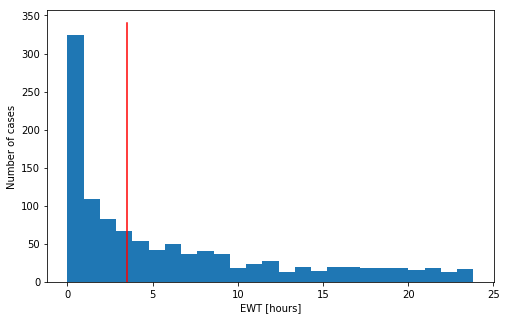

In [38]:
plt.figure(figsize=FIGSIZE)
plt.hist(EWT, 25)
xmin, xmax, ymin, ymax = plt.axis()
plt.plot([median_EWT,median_EWT],[ymin,ymax], '-r'); 
plt.ylabel('Number of cases')
plt.xlabel('EWT [hours]')
print("Median Early Warning Time: " + str(median_EWT) +  " hours")